In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report  #混淆矩阵
from sklearn import metrics

from sklearn import metrics
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# 创建预测图目录
import os  
# 获取当前工作目录  
# 判断imgs文件夹是否存在 保存结果图片 
imgs_path = './model'
if not os.path.exists(imgs_path):  
    # 如果不存在，则创建imgs文件夹  
    os.makedirs(imgs_path)

图的边的特征列名

In [2]:
edge_f = ['Duration', 'FlowBytesSent', 'FlowSentRate',
       'FlowBytesReceived', 'FlowReceivedRate', 'PacketLengthVariance',
       'PacketLengthStandardDeviation', 'PacketLengthMean',
       'PacketLengthMedian', 'PacketLengthMode', 'PacketLengthSkewFromMedian',
       'PacketLengthSkewFromMode', 'PacketLengthCoefficientofVariation',
       'PacketTimeVariance', 'PacketTimeStandardDeviation', 'PacketTimeMean',
       'PacketTimeMedian', 'PacketTimeMode', 'PacketTimeSkewFromMedian',
       'PacketTimeSkewFromMode', 'PacketTimeCoefficientofVariation',
       'ResponseTimeTimeVariance', 'ResponseTimeTimeStandardDeviation',
       'ResponseTimeTimeMean', 'ResponseTimeTimeMedian',
       'ResponseTimeTimeMode', 'ResponseTimeTimeSkewFromMedian',
       'ResponseTimeTimeSkewFromMode',
       'ResponseTimeTimeCoefficientofVariation']

读取两种数据

In [3]:
benign = pd.read_csv('l2-benign.csv')

In [4]:
malicious = pd.read_csv('l2-malicious.csv')

标签标注：良性：0  恶性：1

In [5]:
benign['Label'] = 0
malicious['Label'] = 1

数据合并 去除空值  随机筛选2万条数据进行训练和测试

In [6]:
df = pd.concat([benign,malicious]).dropna()

设置随机抽取数据集数量

In [7]:
sample = 3000

In [8]:
# 筛选标签为0的数据  
df_label_0 = df[df['Label'] == 0]   
# 筛选标签为1的数据  
df_label_1 = df[df['Label'] == 1]  
# 从标签为0的数据中随机取sample条  
sample_0 = df_label_0.sample(n=sample, random_state=42)  # 设置random_state以确保结果的可复现性  
# 从标签为1的数据中随机取sample条  
sample_1 = df_label_1.sample(n=sample, random_state=42)  
# 合并样本作为训练集  
data = pd.concat([sample_0, sample_1])  
# 如果需要，保存训练集到CSV文件  
data.to_csv(f'train_set_{sample}.csv', index=False)

In [9]:
data.shape

(6000, 35)

In [10]:
data.head()

,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,Label
8512,192.168.20.111,8.8.8.8,47458,443,2019/12/16 19:32,0.195289,4468,22878.912790,6084,31153.828430,...,0.417545,7.260540e-05,0.008521,0.009222,0.008136,0.000039,0.382191,1.077651,0.924020,0
13762,192.168.20.111,9.9.9.9,40246,443,2019/12/19 23:34,0.125645,2351,18711.448920,4472,35592.343510,...,0.518810,6.056590e-05,0.007782,0.007827,0.007811,0.015544,0.005879,-0.991627,0.994335,0
10124,192.168.20.111,8.8.8.8,49038,443,2019/12/10 1:28,118.016134,513,4.346863,381,3.228372,...,0.922606,3.070000e-10,0.000018,0.015483,0.015473,0.015469,1.769584,0.818195,0.001131,0
2635,192.168.20.111,8.8.8.8,37502,443,2019/12/13 18:05,0.015491,171,11038.667610,105,6778.129236,...,0.707107,0.000000e+00,0.000000,0.015477,0.015477,0.015477,-10.000000,-10.000000,0.000000,0
16230,192.168.20.113,176.103.130.130,41924,443,2019/12/19 19:36,0.021905,128,5843.414745,74,3378.224150,...,0.707107,0.000000e+00,0.000000,0.021895,0.021895,0.021895,-10.000000,-10.000000,0.000000,0


In [11]:
pd.set_option('display.float_format',lambda x:'{:.3f}'.format(x))    #控制输出为精确到小数点后三位
color = sns.color_palette()
sns.set_style('darkgrid')

目标和特征热力图

C:\Users\tojoy\AppData\Local\Temp\ipykernel_47352\1090798881.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = data.corr()
C:\Users\tojoy\AppData\Local\Temp\ipykernel_47352\1090798881.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(corrmat,rotation='horizontal')


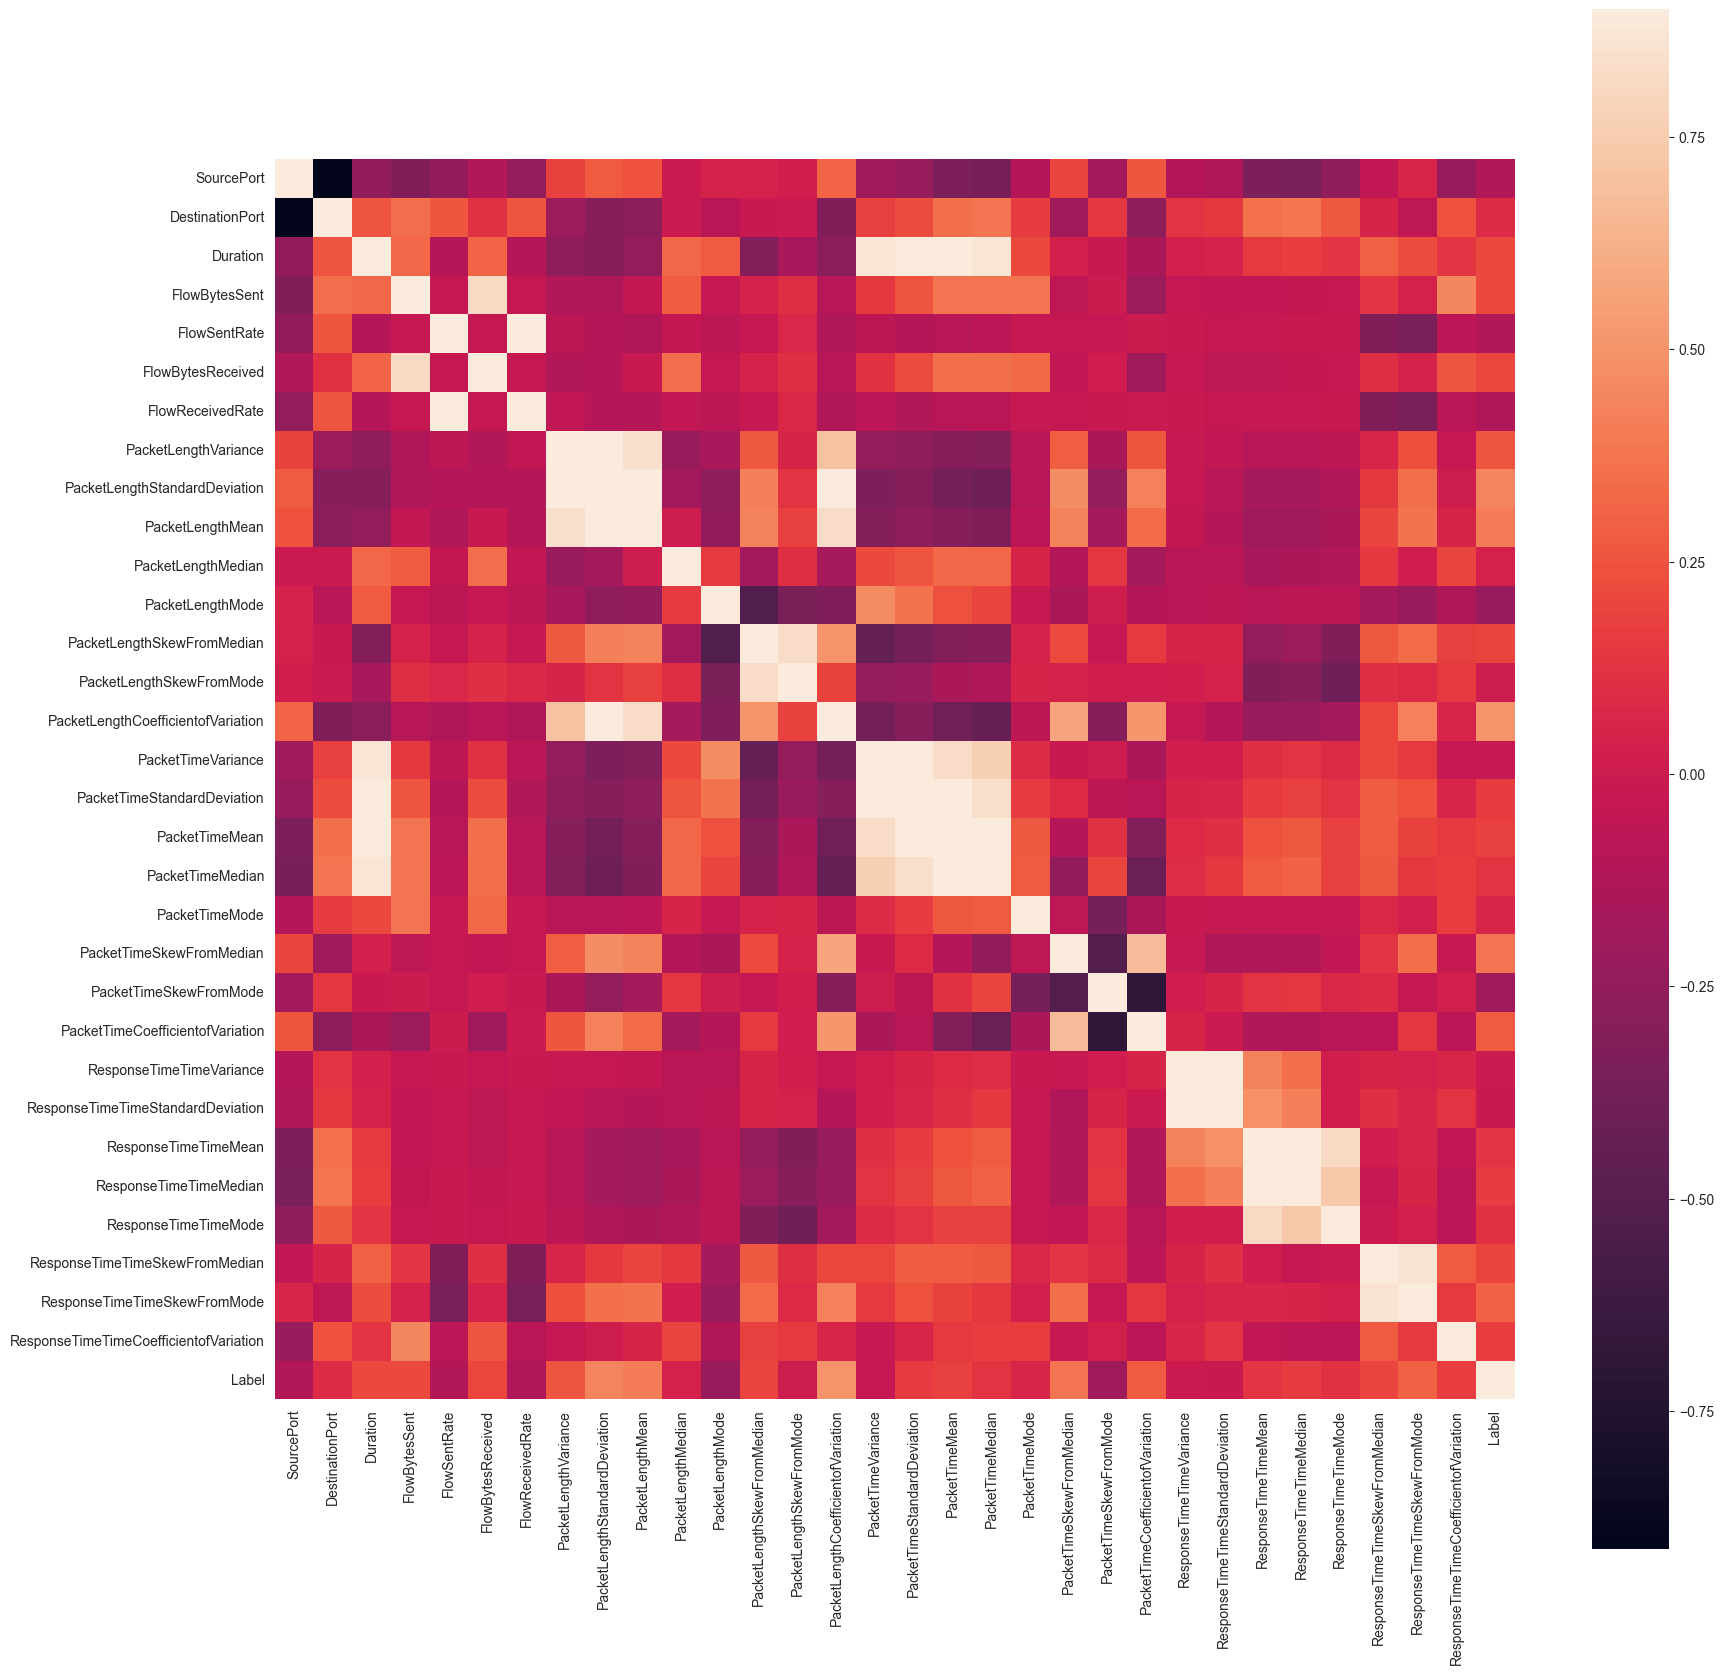

In [12]:
corrmat = data.corr()
f,ax = plt.subplots(figsize=(20,20))
ax.set_xticklabels(corrmat,rotation='horizontal')
sns.heatmap(corrmat, vmax =0.9,square=True)
label_y = ax.get_yticklabels()
plt.setp(label_y , rotation = 360)
label_x = ax.get_xticklabels()
plt.setp(label_x , rotation = 90)
plt.show();

边特征标准化 消除量纲影响

In [13]:
scaler = StandardScaler()
scaler.fit(data[edge_f])
data[edge_f] = scaler.transform(data[edge_f])

In [14]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [15]:
# 3.split data
X, Y = data[edge_f], data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)

In [20]:
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 2,
    'lambda': 10,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'min_child_weight': 100,
    # 'eta': 0.025,
    'eta': 0.01,
    'seed': 0,
    'nthread': 8,
    'silent': 1
}

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 10
bst = xgb.train(params, xg_train, num_round, watchlist)
# xgb = xgb.XGBClassifier(n_estimators=20, max_depth=4,
#    learning_rate=0.1, subsample=0.7, colsample_bytree=0.7)
# xgb.fit(train_X, train_y, early_stopping_rounds=10, eval_metric="auc",
#        eval_set=[(test_X, test_y)])
bst.save_model('xgb_test.model')
y_prob = bst.predict(xg_test)
y_pred = (y_prob >= 0.5) * 1

[0]	train-auc:0.88646	test-auc:0.88858
[1]	train-auc:0.97360	test-auc:0.97919
[2]	train-auc:0.95552	test-auc:0.96550
[3]	train-auc:0.96844	test-auc:0.97490
[4]	train-auc:0.95947	test-auc:0.96846
[5]	train-auc:0.96013	test-auc:0.96887
[6]	train-auc:0.95996	test-auc:0.96918
[7]	train-auc:0.96664	test-auc:0.97273
[8]	train-auc:0.96689	test-auc:0.97264
[9]	train-auc:0.96758	test-auc:0.97391


d:\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [11:23:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [11:23:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


绘制Accuracy图

In [21]:
%matplotlib inline

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       921
           1       0.91      0.93      0.92       879

    accuracy                           0.92      1800
   macro avg       0.92      0.92      0.92      1800
weighted avg       0.92      0.92      0.92      1800



In [23]:
# 二分类评价指标
def evaluate(result, test_y, probas, name = 'mymodel'):
    # 1-1 评估指标
    acc = np.mean([result[i] == test_y[i] for i in range(len(result))])
    precision = metrics.precision_score(test_y,result)
    recall = metrics.recall_score(test_y,result)
    f1 = metrics.f1_score(test_y,result)
    #spe = specificity_loss_func(test_y, result)
    print("准确率:",acc.round(4))
    print("精确率:",precision.round(4))
    print("召回率:",recall.round(4))
    
    print("F1:",f1.round(4))

    # 1-2.混淆矩阵
    confusion_mat = confusion_matrix(test_y, result)
    
    tn, fp, fn, tp = confusion_mat.ravel()
    
    # 计算敏感性和特异性
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print("特异度:",round(specificity,4))
    print("敏感度:",round(sensitivity,4))

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
    disp.plot(
        include_values=True,            
        cmap=plt.cm.Blues,
        ax=None,                        
        xticks_rotation="horizontal",   
        values_format=".2f"
    )
    plt.title(f"{name} confusion matrix")
    plt.grid(False)
    plt.show();

    # ROC曲线
    roc = metrics.roc_auc_score(test_y,probas)
    print("AUC值:",roc.round(4))
    fpr,tpr,thresholds=metrics.roc_curve(test_y,probas)
    plt.plot(fpr,tpr, label=f"{name} ROC curve (area={round(roc,2)})")
    plt.plot([0,1],[0,1],linestyle='dashed')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} ROC")
    plt.legend(loc='lower right')
    plt.grid(linestyle='-.')  
    plt.grid(True)
    plt.show();
    
    #敏感性特异性曲线
    plt.plot(thresholds, 1-fpr, label='specificity')
    plt.plot(thresholds, tpr, label='sensitivity')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Classification Proportion')
    plt.xlabel('Cutoff')
    plt.legend()
    plt.show()    
    
    # PR曲线
    
    precision,recall,thresholds=metrics.precision_recall_curve(test_y,probas)
    plt.plot(recall,precision,color='y',label=name)
    plt.title(f'{name} Precision-recall curve')
    plt.legend(loc='lower left')
    plt.plot([1,0],[0,1],'r--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.grid(linestyle='-.')  
    plt.grid(True)
    plt.show()
    
    return

准确率: 0.92
精确率: 0.9097
召回率: 0.9283
F1: 0.9189
特异度: 0.9121
敏感度: 0.9283


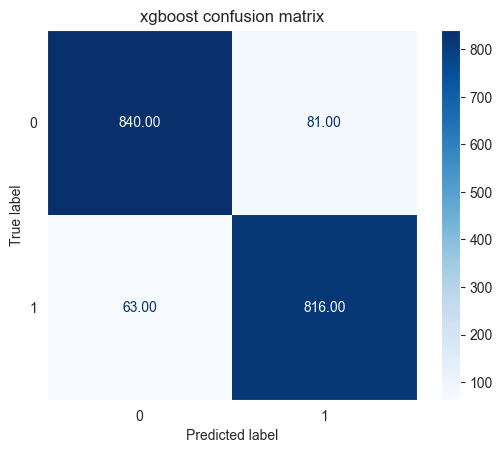

AUC值: 0.9739


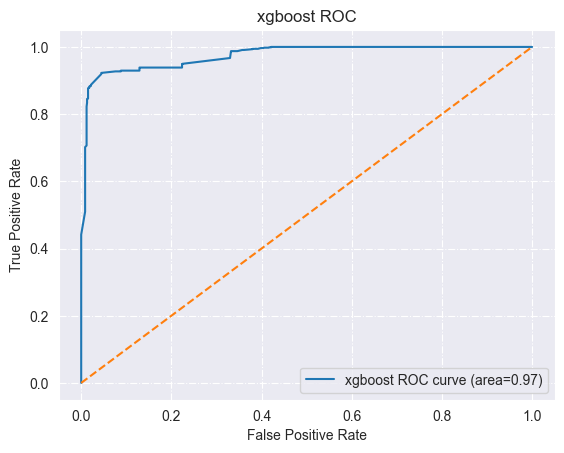

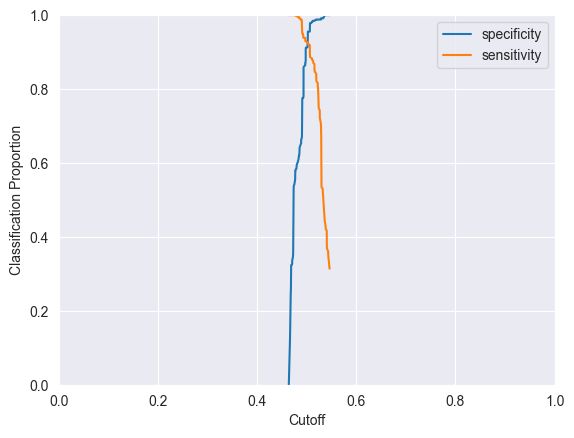

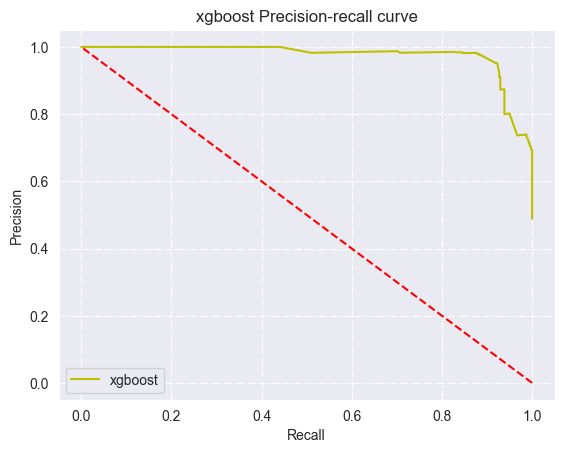

In [24]:
evaluate(y_pred, y_test.values, y_prob, name = 'xgboost')